# Tumor Analysis from CI5-Xd

---


This is an analysis of tumor incidence in 7 global regions (WHO regions, with America split into USA/Canada and Latin America) from data in the CI5-Xd database. The database can be downloaded here: http://ci5.iarc.fr/CI5-X/Pages/download.aspx (Use the detailed database.)

First, we'll need to import some libraries.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

We'll define a WHO standard population for the 18 age groups in the CI5 dataset. Ref: https://seer.cancer.gov/stdpopulations/world.who.html

In [2]:
whoStandardPop = np.array([88569, 86870, 85970, 84670, 82171,
                  79272, 76073, 71475, 65877, 60379,
                  53681, 45484, 37187, 29590, 22092, 
                  15195,  9097, (4398+1500+400+50), 0])/10     # Add a 0 on the end for the 'Unknown' classification
round(sum(whoStandardPop))                                     # Standard population sums to 100,000

100000.0

Next, we'll define some locations where the data are. The registry list should be in CSV format, with a row for each registry. The columns list:

1. A numeric code denoting the identity of the registry, corresponding to the name of the CSV file with data from that registry.
2. A text description of the registry.
3. A numeric code listing which region the registry corresponds to: 
         1- 'AFR'
         2- 'AMR-L'
         3- 'AMR-US'
         4- 'EMR'
         5- 'WPR'
         6- 'SEAR'
         7- 'EUR'
4. A numeric code denoting the WorldBank income level of the country the registry covers:
        1- Low income
        2- Lower middle income
        3- Higher middle income
        4- High income
5. A numeric flag denoting whether to use the registry in the calculation. 0- Don't use. 1- Use.

In [3]:
regionList = ['AFR   ', 'AMR-L ', 'AMR-US', 'EMR   ', 'WPR   ', 'SEAR  ', 'EUR   ']
incomeList = ['LIC ', 'LMIC', 'HMIC', 'HIC ']
ageList = [ '0-4', '5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49',
           '50-54','55-59','60-64','65-69','70-74','75-79','80-84','85+','Unknown']
dataDir = './CI5-Xd/CSV/'
registryListCSV = './CI5-Xd/registryCSV.csv'

Import the registry list as a DataFrame. Skip the 1st row, and add our own descriptions for the columns. We'll just display the first few registries from the list.

In [4]:
registryList = pd.read_csv(registryListCSV, skiprows=1, names=['RegN', 'Description', 'Region', 'Income', 'Use'])
registryList.iloc[1:12]

,RegN,Description,Region,Income,Use
1,14340199,"Libya, Benghazi (2003-2005)",1,3,1
2,14540199,"Malawi, Blantyre (2003-2007)",1,1,1
3,17100199,"South Africa, PROMEC (2003-2007)",1,3,1
4,17160270,"Zimbabwe, Harare: African (2003-2006)",1,1,1
5,17880299,"Tunisia, North (2003-2005)",1,2,1
6,18000299,"Uganda, Kyadondo County (2003-2007)",1,1,1
7,18180299,"Egypt, Gharbiah (2003-2007)",1,2,1
8,20320199,"Argentina, BahÌa Blanca (2003-2007)",2,3,1
9,20320699,"Argentina, CÛrdoba (2004-2007)",2,3,1
10,20320799,"Argentina, Mendoza (2003-2007)",2,3,1


Now we need to define what age range and tumor types we'll use. 

Group codes are indexed 1-19, corresponding to ages 0-4, 5-9, 10-14, 15-19,..., 80-84, 85+, Unknown.

Sex is coded 1: male, 2: female.

Tumors are described in cancer.txt. Relevant codes are:

    173 Eye, brain and central nervous system (C69-72)
    174 Eye (C69)
    175 	Retinoblastoma
    176 	Melanoma
    177 	Squamous cell carcinoma
    178 	Other specified carcinoma
    179 	Unspecified carcinoma
    180 	Sarcoma
    181 	Other morphology
    182 	Unspecified morphology
    183 Meninges (C70)
    184 Central nervous system (C71-72)
    185 	Astrocytic tumours
    186 	Oligodendroglial tumours and mixed gliomas
    187 	Ependymal tumours
    188 	Gliomas of uncertain origin
    189 	Medulloblastoma
    190 	Other embryonal tumours
    191 	Other neuroepithelial tumours
    192 	Other specified morphology
    193 	Unspecified morphology
    194 Brain (C71)
    195 Other parts of central nervous system (C72)
    196 	Spinal cord, cauda equina (C72.0,1)
    197 	Cranial nerves (C72.2-5)
    198 	Nervous system, NOS (C72.8-9)

Listing any of these codes in the variable `useTumors` below will include them in the analysis. Similarly, the age groups and patient sexes used in the analysis can be restricted below.

In [5]:
useAges   = np.array([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])       # Use ages 15-85+
useSexes  = [1,2]                                                    # Use both male and female
useTumors = [183,194]                                                
# Use 183, 194 for Meningioma and brain tumors (C70, C71)
# Use 196 for Spine and cauda tumors (C72.0-1)

Now for each region, we'll load the data from each registry and extract the records that meet our search critera based on age, sex, and tumor type, and store the data in a dictionary called: `regionData[]`

In [6]:
# Make an empty dict to aggregate registry data for each region, and each WorldBank Income zone.
regionData = dict()
incomeData = dict()

# Loop through all the regions we need to analyze...
for regionN in range(1, 8):
    
    # Initialize the dict with an empty dataframe for that region
    regionData[regionN] = pd.DataFrame()
    
    # Find the registries for this region that we want to use.
    regionRegs = registryList[np.logical_and(registryList['Region'] == regionN, registryList['Use'] > 0)]   
    print(str(regionN) + ': ' + regionList[regionN-1] + ' - # Registries found: ' + str(len(regionRegs.index)))
      
    # For each registry that we want to use...
    for row in regionRegs.itertuples():
        
        # Import the CSV file that corresponds to each registry.
        regDataFilename = dataDir + str(row.RegN) + '.csv'
        
        try:
            regData = pd.read_csv(regDataFilename, skiprows=0, names=['Sex', 'Cancer', 'Age', 'Cases', 'PersonYears'])

            # Select the data from that registry that meets our search criteria.
            sexOK    = np.in1d(regData['Sex'],useSexes)
            cancerOK = np.in1d(regData['Cancer'],useTumors)
            okData = regData[np.logical_and(sexOK, cancerOK)]

            # Aggregate it into a dataframe for the region.
            regionData[regionN] = pd.concat([regionData[regionN], okData])
        except:
            print('   Data missing: ' + regDataFilename + ', ' + row.Description)
            pass 

print(' ')        
        
# Loop through all the regions we need to analyze...
for incomeN in range(1, 5):
    
    # Initialize the dict with an empty dataframe for that income zone
    incomeData[incomeN] = pd.DataFrame()
    
    # Find the registries for this income that we want to use.
    incomeRegs = registryList[np.logical_and(registryList['Income'] == incomeN, registryList['Use'] > 0)]   
    print(str(incomeN) + ': ' + incomeList[incomeN-1] + ' - # Registries found: ' + str(len(incomeRegs.index)))
      
    # For each registry that we want to use...
    for row in incomeRegs.itertuples():
        
        # Import the CSV file that corresponds to each registry.
        regDataFilename = dataDir + str(row.RegN) + '.csv'
        
        try:
            regData = pd.read_csv(regDataFilename, skiprows=0, names=['Sex', 'Cancer', 'Age', 'Cases', 'PersonYears'])

            # Select the data from that registry that meets our search criteria.
            sexOK    = np.in1d(regData['Sex'],useSexes)
            cancerOK = np.in1d(regData['Cancer'],useTumors)
            okData = regData[np.logical_and(sexOK, cancerOK)]

            # Aggregate it into a dataframe for the region.
            incomeData[incomeN] = pd.concat([incomeData[incomeN], okData])
        except:
            print('   Data missing: ' + regDataFilename + ', ' + row.Description)
            pass 

1: AFR    - # Registries found: 8
2: AMR-L  - # Registries found: 25
3: AMR-US - # Registries found: 2
4: EMR    - # Registries found: 5
5: WPR    - # Registries found: 36
   Data missing: ./CI5-Xd/CSV/60360199.csv, Australian Capital Territory (2003-2007)
6: SEAR   - # Registries found: 18
7: EUR    - # Registries found: 114
 
1: LIC  - # Registries found: 3
2: LMIC - # Registries found: 17
3: HMIC - # Registries found: 52
4: HIC  - # Registries found: 136
   Data missing: ./CI5-Xd/CSV/60360199.csv, Australian Capital Territory (2003-2007)


If we look at each of these regions, the population structures are pretty different. If we go through the data and calculate the fraction of each population in our collection of registries in each age bin, you can see that the AFR and EMR regions skew very young, and while AMR-US and EUR skew very old. The population structure of the WHO standard population is plotted as a dotted line for reference.

We can also plot the total person-years at risk in the sample. (Note the log-scale.) This gives a sense of the relative amount of surveillance captured by these datasets in the different regions. Note that some regions fall off steeply after the 75+ age groups. This is because some registries aggregate all ages over 75 into one bin, so higher bins are empty.

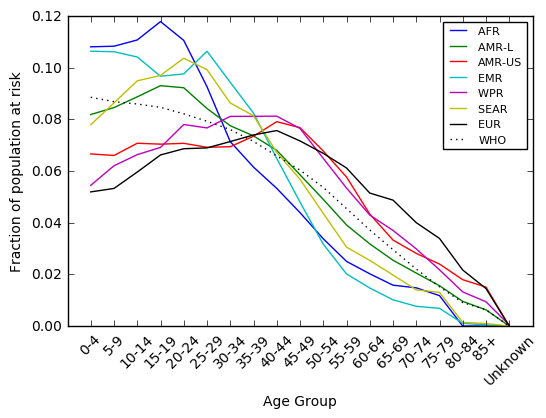

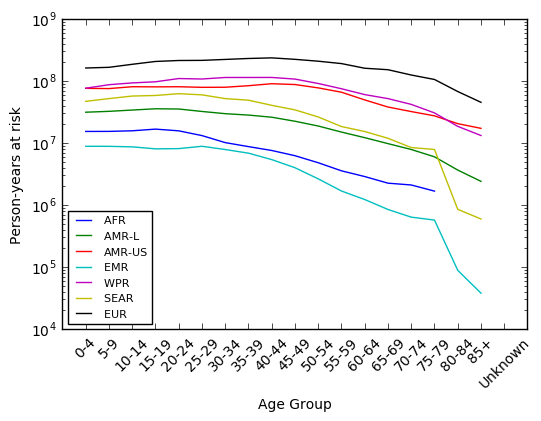

In [7]:
for regionN in range(1, 8):
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
        
    plt.figure(1)
    plt.plot(np.arange(1,20), personYears/sum(personYears),'-',label=regionList[regionN-1]) 
    
    plt.figure(2)
    personYears[personYears < 10**4] = float('NaN') # Don't plot ages with very few person-years
    plt.plot(np.arange(1,19), personYears[0:18],'-',label=regionList[regionN-1])


plt.figure(1)
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of population at risk')    
plt.plot(np.arange(1,20), whoStandardPop/sum(whoStandardPop),'k:',label='WHO')
plt.legend(loc='upper right',prop={'size':8})

plt.figure(2)
ax = plt.gca()
ax.set_yscale('log')
plt.ylim(10**4,10**9)
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Person-years at risk')    
plt.legend(loc='lower left',prop={'size':8})


Looking number of cases recorded across age groups (normalized for the total number of cases, but not the population at risk) we can see the registries in all regions are filled with tumors of middle-aged people, with an upswing in some populations of pediatric tumors.

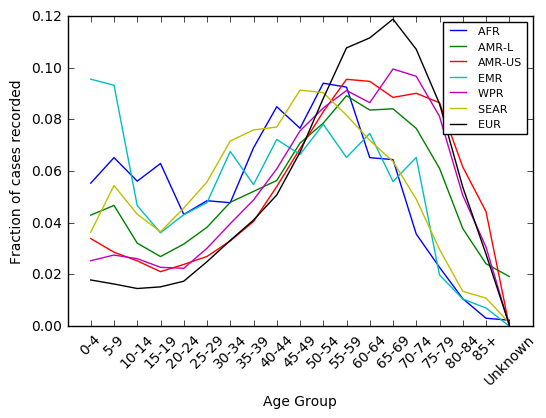

In [8]:
for regionN in range(1, 8):
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000 
    
    plt.figure(2)
    plt.plot(np.arange(1,20), cases[np.arange(1,20)-1]/sum(cases),'-',label=regionList[regionN-1])   

ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of cases recorded')
plt.legend(loc='upper right',prop={'size':8})

To compare regions with different population structures, for each region we need to calculate age-standardized rates (ASRs), and confidence intervals. Note that this estimate is weighted to account for differences in population structure, but not to account for differences in data coverage in each age group. We do this after *(Boyle 1991)*: 

    Boyle, P., and D. M. Parkin. "Statistical methods for registries." Cancer registration: principles and methods 95 (1991): 126-158.

We calculate truncated age standardized rates over the age-group indices in `useAges`. Where $n_{i}$ is the number of cases for age-group $i$, $y_{i}$ is the number of person-years at risk for age-group $i$, and $w_{i}$ is the world standard population for age-group $i$, the truncated age standardized rate per 100,000 population is:

$$ASR_t = \frac{\sum_{i}^{useAges}n_{i}w_{i}/y_{i}}{\sum_{i}^{useAges}w_{i}} * 100,000 $$

To calculate confidence intervals, we consider incidence as a Poisson process, so the variance is equal to the mean rate. Variance of the component age groups will add geometrically, so the standard error is:

$$S.E.(ASR_t) = \sqrt{\sum_{i}^{useAges}(\frac{w_i}{\sum_{j}^{useAges}w_j})^{2}(\frac{n_{i}}{y_{i}^{2}})}*100,000 $$

The 95% confidence intervals are approximated as:

$$ ASR_t \pm 1.96 * S.E.(ASR_t) $$

Functions to implement these are given below, including testing datasets drawn from *Boyle*.

In [9]:
# Functions to calculate the ASR and SE of the ASR, test data below
# -----------------------------------------------------------------
# n: number of cases, y: number of person years, w: standard pop, 
# useAges: age indices to use.
def calculateASR(n, y, w, useAges):
    # If there's missing population data (y = 0) then don't use those ages.
    ageIX = np.in1d(np.arange(1,20),useAges)
    ageIX[y < 1] = 0
    
    ASR = sum(n[ageIX]*w[ageIX]/y[ageIX])/sum(w[ageIX])*100000
    return ASR

def calculateASRSE(n, y, w, useAges):
    # If there's missing population data (y = 0) then don't use those ages.
    ageIX = np.in1d(np.arange(1,20),useAges)
    ageIX[y < 1] = 0
    
    totUsePop = sum(w[ageIX])
    varASR = sum((w[ageIX]/totUsePop)**2 * (n[ageIX]/(y[ageIX]**2)))
    seASR = math.sqrt(varASR)*100000
    return seASR

Test data from *Boyle*, Example 3, ASR should equal 124.98

In [10]:
tuseAges = np.arange(8,14)
tn = np.array([0,0,0,0,0,0,0,7.48, 21.12,53.2,128.16,263.17,422.49,
           0,0,0,0,0,0])
tw = np.array([0,0,0,0,0,0,0,6000,6000,6000,5000,4000,4000,
     0,0,0,0,0,0])
ty = np.array([0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0])*100000
print("%.2f" % calculateASR(tn, ty, tw, tuseAges))

124.98


Test data from *Boyle*, Example 5. S.E. of ASR should equal 0.73

In [11]:
tuseAges = np.arange(1,19)
tw = np.array([ 12000, 10000, 9000, 9000, 8000,
                8000,  6000, 6000, 6000, 6000,
                5000,  4000, 4000, 3000, 2000,
                1000,   500,  500,    0])
ty = np.array([827400, 856500, 1061500, 1157400, 1074900,
              917700, 890300,  816000,  724400,  706800,
              703800, 691200,  610900,  511800,  425600,
              266800, 122500,   54700,      0])
ta = np.array([0, 0, 0, 0, 0.37,
              0.33, 3.26, 7.48, 21.12, 53.2,
              128.16, 263.17, 422.49, 600.04, 780.55,
              919.04, 981.22, 784.28, 0])
tn = ta*ty/100000
print("%.2f" % calculateASRSE(tn, ty, tw, tuseAges))

0.73


Now we'll go through each region to calculate the ASR. We'll also plot the raw age-specific rates for each region, which divides out differences in population structure to give use case rates for each age.

1: AFR   
	 ASR:   1.40 +/- 0.04 
	 # Cases: 1294
	 # Person-years: 142502260
	 Raw rate: 0.91
2: AMR-L 
	 ASR:   2.62 +/- 0.03 
	 # Cases: 8093
	 # Person-years: 384242922
	 Raw rate: 2.11
3: AMR-US
	 ASR:   3.20 +/- 0.02 
	 # Cases: 36830
	 # Person-years: 1145715214
	 Raw rate: 3.21
4: EMR   
	 ASR:   1.81 +/- 0.09 
	 # Cases: 850
	 # Person-years: 83442084
	 Raw rate: 1.02
5: WPR   
	 ASR:   2.06 +/- 0.01 
	 # Cases: 28236
	 # Person-years: 1408038808
	 Raw rate: 2.01
6: SEAR  
	 ASR:   1.63 +/- 0.02 
	 # Cases: 7075
	 # Person-years: 604120222
	 Raw rate: 1.17
7: EUR   
	 ASR:   3.36 +/- 0.01 
	 # Cases: 114045
	 # Person-years: 3128749888
	 Raw rate: 3.65


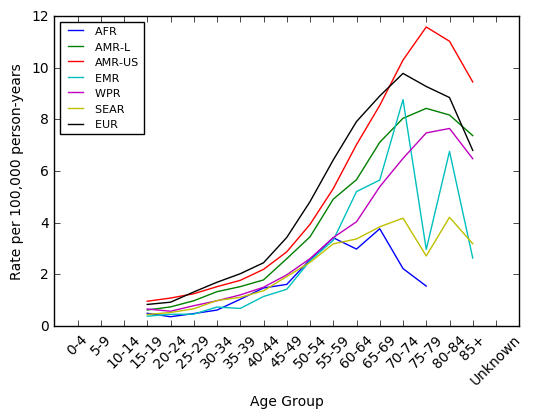

In [12]:

for regionN in range(1, 8):
    print(str(regionN) + ': '+ regionList[regionN-1])
    data = regionData[regionN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    ASR   = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRse = calculateASRSE(cases, personYears, whoStandardPop, useAges)
    
    print("\t ASR:   %.2f +/- %.2f " % (ASR, ASRse))
    print("\t # Cases: %d" % sum(cases))
    print("\t # Person-years: %d" % sum(personYears))
    rawRate = sum(cases)/sum(personYears)*100000
    print("\t Raw rate: %.2f" % rawRate)

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=regionList[regionN-1])   
    ax = plt.gca()
    ax.set_xticks(np.arange(1,20))
    ax.set_xticklabels(ageList, rotation=45)
    # plt.ylim(0,13)
    plt.xlim(0,20)
    plt.xlabel('Age Group')
    plt.ylabel('Rate per 100,000 person-years')
    plt.legend(loc='upper left',prop={'size':8})
    

Returning to the income groups, we can similarly plot the population structures for those:

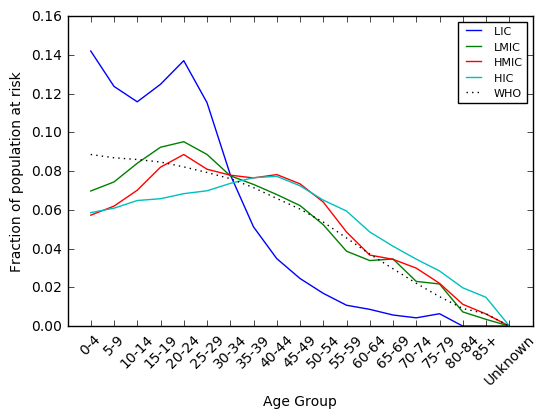

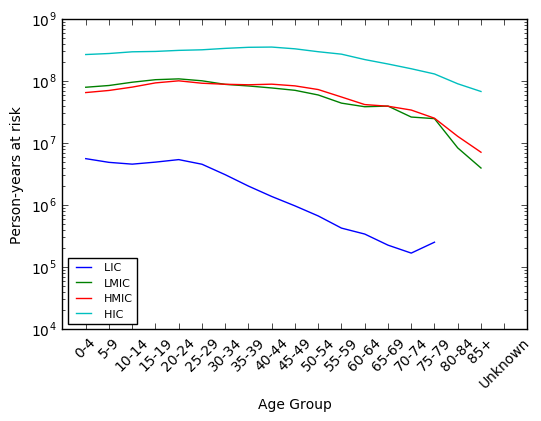

In [13]:
for incomeN in range(1, 5):
    data = incomeData[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        ageD = data[data['Age'] == ageN]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
        
    plt.figure(1)
    plt.plot(np.arange(1,20), personYears/sum(personYears),'-',label=incomeList[incomeN-1]) 
    
    plt.figure(2)
    personYears[personYears < 10**4] = float('NaN')
    plt.plot(np.arange(1,19), personYears[0:18],'-',label=incomeList[incomeN-1])


plt.figure(1)
ax = plt.gca()
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Fraction of population at risk')    
plt.plot(np.arange(1,20), whoStandardPop/sum(whoStandardPop),'k:',label='WHO')
plt.legend(loc='upper right',prop={'size':8})

plt.figure(2)
ax = plt.gca()
ax.set_yscale('log')
plt.ylim(10**4,10**9)
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(ageList, rotation=45)
plt.xlim(0,20)
plt.xlabel('Age Group')
plt.ylabel('Person-years at risk')    
plt.legend(loc='lower left',prop={'size':8})

Lower income groups have a younger population structure, and less data available for estimates. 

We can also calculate ASRs for each income group:

1: LIC 
	 ASR:   0.71 +/- 0.09 
	 # Cases: 124
	 # Person-years: 39509966
	 Raw rate: 0.31
2: LMIC
	 ASR:   2.04 +/- 0.02 
	 # Cases: 19387
	 # Person-years: 1140671102
	 Raw rate: 1.70
3: HMIC
	 ASR:   2.71 +/- 0.02 
	 # Cases: 28204
	 # Person-years: 1140126454
	 Raw rate: 2.47
4: HIC 
	 ASR:   3.09 +/- 0.01 
	 # Cases: 148708
	 # Person-years: 4576503876
	 Raw rate: 3.25


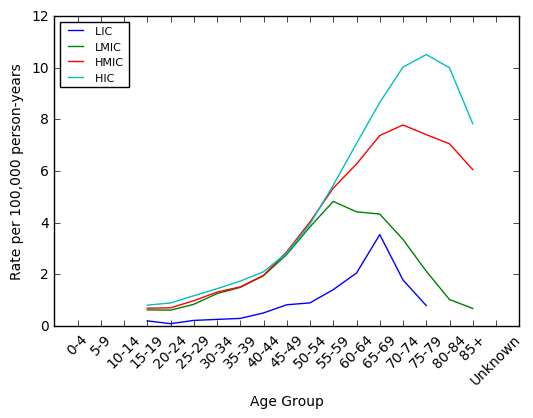

In [14]:
for incomeN in range(1, 5):
    print(str(incomeN) + ': '+ incomeList[incomeN-1])
    data = incomeData[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    ASR   = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRse = calculateASRSE(cases, personYears, whoStandardPop, useAges)
    
    print("\t ASR:   %.2f +/- %.2f " % (ASR, ASRse))
    print("\t # Cases: %d" % sum(cases))
    print("\t # Person-years: %d" % sum(personYears))
    rawRate = sum(cases)/sum(personYears)*100000
    print("\t Raw rate: %.2f" % rawRate)

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=incomeList[incomeN-1])   
    ax = plt.gca()
    ax.set_xticks(np.arange(1,20))
    ax.set_xticklabels(ageList, rotation=45)
    # plt.ylim(0,13)
    plt.xlim(0,20)
    plt.xlabel('Age Group')
    plt.ylabel('Rate per 100,000 person-years')
    plt.legend(loc='upper left',prop={'size':8})

High income groups show greater incidence of these tumors.

Because sampling of the low income countries is so poor, it probably makes sense to group LIC with LMIC, and HIC with HMIC to create two groups.

1: LIC/LMIC
	 ASR:   2.02 +/- 0.02 
	 # Cases: 19511
	 # Person-years: 1180181068
	 Raw rate: 1.65
2: HMIC/HIC
	 ASR:   3.02 +/- 0.01 
	 # Cases: 176912
	 # Person-years: 5716630330
	 Raw rate: 3.09


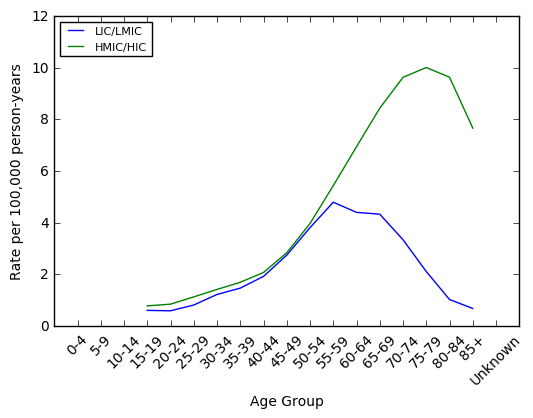

In [15]:
# Concatenate the 4-group income data into a DataFrame of 2 income groups.
incomeData2 = dict()
incomeData2[1] = pd.concat([incomeData[1],incomeData[2]])
incomeData2[2] = pd.concat([incomeData[3],incomeData[4]])
incomeList2 = ['LIC/LMIC', 'HMIC/HIC']

for incomeN in range(1, 3):
    print(str(incomeN) + ': '+ incomeList2[incomeN-1])
    data = incomeData2[incomeN]
    
    cases       = np.zeros(19)
    personYears = np.zeros(19)
    ageRate     = np.zeros(19)
    
    for ageN in np.arange(1,20):
        # Only take records that have PersonYears > 0
        ageD = data[np.logical_and(data['Age'] == ageN,data['PersonYears'] > 0)]
        cases[ageN-1]       = sum(ageD['Cases'])
        personYears[ageN-1] = sum(ageD['PersonYears'])
        ageRate[ageN-1] = cases[ageN-1]/personYears[ageN-1]*100000
   
    ASR   = calculateASR(cases, personYears, whoStandardPop, useAges)
    ASRse = calculateASRSE(cases, personYears, whoStandardPop, useAges)
    
    print("\t ASR:   %.2f +/- %.2f " % (ASR, ASRse))
    print("\t # Cases: %d" % sum(cases))
    print("\t # Person-years: %d" % sum(personYears))
    rawRate = sum(cases)/sum(personYears)*100000
    print("\t Raw rate: %.2f" % rawRate)

    plt.figure(3)
    plt.plot(useAges, ageRate[useAges-1],'-',label=incomeList2[incomeN-1])   
    ax = plt.gca()
    ax.set_xticks(np.arange(1,20))
    ax.set_xticklabels(ageList, rotation=45)
    # plt.ylim(0,13)
    plt.xlim(0,20)
    plt.xlabel('Age Group')
    plt.ylabel('Rate per 100,000 person-years')
    plt.legend(loc='upper left',prop={'size':8})